# Kaggle Digit Recognizer Challenge
Amalie Rand, Andy Vu Ngoc & Ayah Bouguerra


This notebook provides our solution for the Kaggle Digit Recognizer challenge. The purpose of the challenge is to classify handwritten digits from the MNIST dataset using deep learning. We have chosen to implement a simple CNN with two convolutional layers and maxpooling to classify the digit images. In this notebook the following structure is presented:

- Pre-processing: Data loading and visualisation 
- CNN 
- Training and evaluation
- Visualisation of filters
- Results

In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim #for optimisation
from torch.utils.data import DataLoader #for loading the data in batches
import numpy as np 
from collections import Counter # for counting classes
from sklearn.metrics import classification_report, confusion_matrix #for the final classification report of f1-score, precision, recall and average accuracy
import matplotlib.pyplot as plt #for plotting
from sklearn.metrics import confusion_matrix
import seaborn as sns #for confusion matrix heatmap

## Pre-processing: Data loading and visualisation

MNIST images are loaded using torchvisions transforms.ToTensor() converting the image into a tensor with pixel values in the range [0,1]. The images are then normalised using mean = 0.5 and std = 0.5 as parameters, which maps the values form [0,1] to  [-1,1], so the dataset is roughly centered around 0. This normalisation is used because the CNN usually trains better when all inputs are not positive, so this will make training more stable.

The training and test set are then defined and loaded and wrapped in Dataloader to enable batch loading and shuffling during training

For visualisation, a small set of samples from each dataset is plotted using matplotlib. Since the MNIST tensors have shape (1, 28, 28), the plotting function uses squeeze() to remove the channel dimension before displaying the images in grayscale.

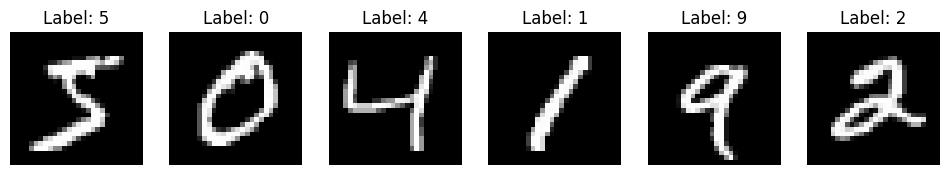

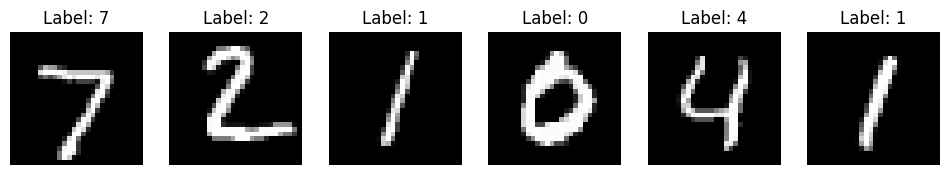

In [ ]:
root_dir = '/Users/amalierand/Desktop/Exchange-courses/Image-processing/DL-project'

tensor = torchvision.transforms.ToTensor()
normalize = torchvision.transforms.Normalize((0.5,), (0.5,))
transform = torchvision.transforms.Compose([tensor, normalize])

train_dataset = torchvision.datasets.MNIST(root=root_dir, train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.MNIST(root=root_dir, train=False, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

def plot_images(dataset):
    fig, axes = plt.subplots(1, 6, figsize=(12, 3))
    for i, ax in enumerate(axes):
        image, label = dataset[i]
        image = image.squeeze().numpy()
        ax.imshow(image, cmap='gray')
        ax.set_title(f'Label: {label}')
        ax.axis('off')
    
    plt.show()

plot_images(train_dataset)
plot_images(test_dataset)

The class distribution is inspected using Counter, to see if the dataset is imablanced and if class weights should be used during training:

In [37]:
#showing class distribution
print(Counter(train_dataset.targets.numpy()))

Counter({1: 6742, 7: 6265, 3: 6131, 2: 5958, 9: 5949, 0: 5923, 6: 5918, 8: 5851, 4: 5842, 5: 5421})


This shows that all 10 classes are pretty evenly distributed and no class weights are needed

## CNN

To classify the digits in the MNIST images we chose a classic, simple CNN, since the convolutional layers can detect local patterns such as edges and textures by applying small filters across the images, capturing the actual spatial structure of the digits.

The CNN consists of two feature extraction blocks each consisting of a convolutional layer, ReLU activation function and a max pooling layer. The first convolution takes the single-channel grayscale image as input and outputs 16 feature maps; the second increases this to 32. Both layers use 3×3 kernels with stride 1 and padding 1, to preserve the resolution of the image. Maxpooling is used, which downsamples the feature maps by taking the maximum value within each 2x2 region to reduce spatial resolution and provide translation invariance, meaning the model can still correctly predict the digit even if it is shifted slightly in the image. ReLU activation was used, as it is a standard activation function in CNN's to introduce non-linearity so the CNN can learn more complex relationships between the features. 

After the two convolutional blocks, the resulting 32 feature maps of size 7×7 are flattened and passed to a fully connected linear layer that outputs ten logits corresponding to the ten classes. 

We use stochastic gradient descent with a learning rate of 1e-2 for stable optimisation behaviour. The cost function used is cross-entropy loss, which compares the predicted logits with the correct class labels and "punishes" incorrect predictions more strongly the more confident they are. Cross-entropy uses softmax to convert these outputs into class probabilities, so it works well with the final linear layer. Since the cross-entropy loss function applies a softmax operation, the final layer outputs raw, unnormalised class scores.

In [ ]:
def CNN(image_channels, nr_of_classes): #defining CNN
    model = nn.Sequential( 
        nn.Conv2d(in_channels=image_channels, out_channels=16, kernel_size=3, stride=1, padding=1), #first conv layer
        nn.ReLU(), #activation function
        nn.MaxPool2d(kernel_size=2, stride=2), #pooling layer
        nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1), #second conv layer
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Flatten(), #flattening 2d matrices to 1d vectors
        nn.Linear(32 * 7 * 7, nr_of_classes)) #fully connected layer
    return model

model = CNN(image_channels=1, nr_of_classes=10) #MNIST has 1 channel (grayscale) and 10 classes 
optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay=0.0001) #stochastic gradient descent
criterion = nn.CrossEntropyLoss() #cross-entropy loss


## Training and evaluation

At the beginning of each epoch, the model is set to training mode, and for each batch of images and labels in the training set, a forward pass is performed to compute predictions, the loss is calculated, gradients are reset, backpropagation is applied, and the optimiser updates the model parameters accordingly.

After each epoch, the model is switched to evaluation mode to compute validation performance on the test set. For each batch in the test set, the validation loss is collected, and predictions are obtained by taking the class with the highest output logit. The total number of correct predictions is tracked to compute the validation accuracy, while true and predicted label lists are stored for confusion matrices or per-class performance metrics. Finally, the average validation loss and accuracy for the epoch are printed, allowing training progress and model convergence to be monitored across every epoch.

In [ ]:
for epoch in range(40): #defining epoch range
    model.train() #setting model to training
    for images, labels in train_loader: #iterating through batches
        outputs = model(images) #forward pass
        loss = criterion(outputs, labels) #computing loss

        optimizer.zero_grad() #setting gradients to zero
        
        loss.backward() #backpropagation
        
        optimizer.step() #updating the weights
        
    model.eval() #setting model to evaluation
    correct = 0 #correct predictions
    total = 0 #total predictions
    validation_loss = 0.0 
    number_of_batches = 0 
    
    #storing true and predicted labels for classification report and confusion matrix
    true_labels = [] 
    predicted_labels = []
    with torch.no_grad(): #computing validation metrics without gradients
        for images, labels in test_loader: 
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            
            validation_loss += loss.item() 
            number_of_batches += 1
            
            _, predicted = torch.max(outputs.data, 1) #getting the predicted class
            #adding true and predicted labels to the previously defined lists
            true_labels.extend(labels.tolist()) 
            predicted_labels.extend(predicted.tolist())
            
            total += labels.size(0) #total number of labels
            correct += (predicted == labels).sum().item() #number of correct predictions
            
            
        
    validation_accuracy = correct / total
    
    validation_loss = validation_loss / number_of_batches
    print(f'Epoch {epoch + 1}, Validation Loss: {validation_loss:.4f}, Validation Accuracy: {validation_accuracy:.4f}')

### Visualising  convolution filters

To better understand what the CNN has learned, we visualise the filters (kernels) of the first
convolutional layer. Each filter is a small 3×3 kernel that is convolved over the input image to
detect specific local patterns. These filters are learned automatically from data
during training.

By plotting the filters as small grayscale images, we can interpret them as detectors of simple
structures such as horizontal or vertical edges, diagonal strokes, or small blobs. These
features are the building blocks that the deeper layers combine into more complex digit shapes.


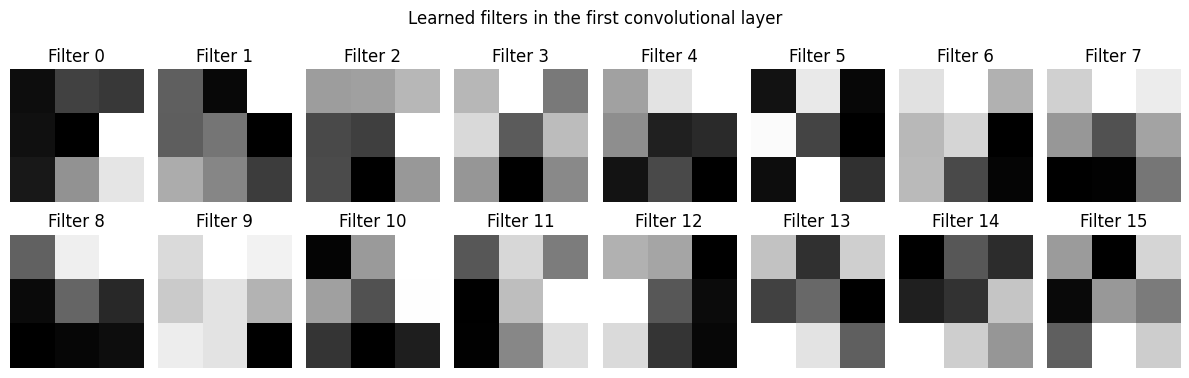

In [ ]:
#visualising learned filters from the first convolutional layer
conv1 = model[0]  #first layer in nn.Sequential

weights = conv1.weight.data.clone()  #shape is (out_channels, in_channels, kH, kW)

out_channels = weights.shape[0] #number of filters

#plotting the filters
fig, axes = plt.subplots(2, out_channels // 2, figsize=(12, 4))
axes = axes.flatten()

#iterating through each filtr
for i in range(out_channels):
    #for MNIST we have 1 input channel, so we can squeeze it:
    kernel = weights[i, 0].cpu().numpy()
    axes[i].imshow(kernel, cmap="gray")
    axes[i].set_title(f"Filter {i}")
    axes[i].axis("off")

plt.suptitle("Learned filters in the first convolutional layer")
plt.tight_layout()
plt.show()


These kernels represent the learned weights of the first convolutional layer in the CNN. It is evident that every filter shows different patterns of positive and negative weights, for example filter 9 shows strong activation in the bottom right corner and filter 0 and 12 detect left and right edges, respectively. This shows how the CNN learns different local patterns it can combine to classify the images.

## Results

### Confusion matrix

To visualise how well the classifier works a confusion matrix is computed because ti shows the true and predicted labels (digits). The diagonal entries are the correct predictions and every off-diagonal entry is incorrect predictions, so it provides a clear picture of the performance, for each class, of the classifier. 

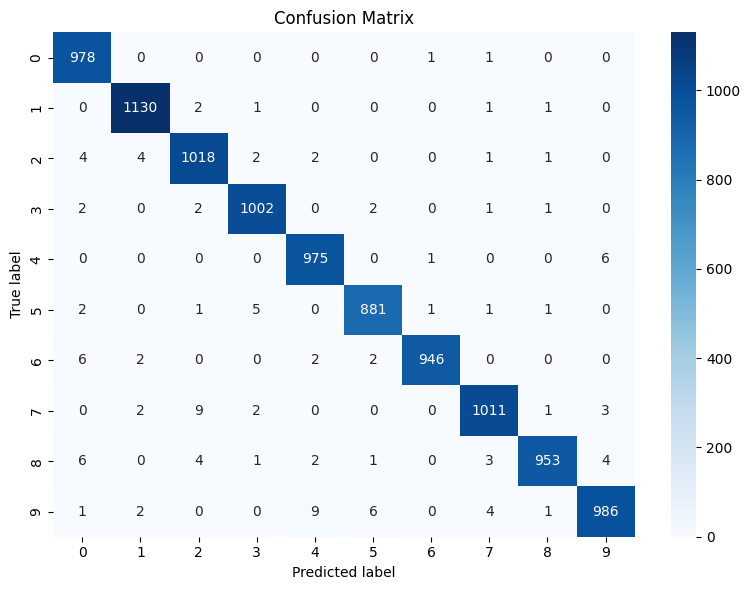

In [ ]:
# Compute confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=range(10), yticklabels=range(10))
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()


### Classification report

To further inspect the performance of the model we print a classification report showing precision, recall, f1-score and support for each class and the overall accuracy of the model. This turns the information from the confusion matrix into precise numerical metrics, making it easier to compare class-wise performance.

In [43]:
print(classification_report(true_labels, predicted_labels))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       980
           1       0.99      1.00      0.99      1135
           2       0.98      0.99      0.98      1032
           3       0.99      0.99      0.99      1010
           4       0.98      0.99      0.99       982
           5       0.99      0.99      0.99       892
           6       1.00      0.99      0.99       958
           7       0.99      0.98      0.99      1028
           8       0.99      0.98      0.99       974
           9       0.99      0.98      0.98      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



The result show that CNN performs well on the dataset, achieving an overall accuracy of 99 pct. The validation loss decreases steeply in the beginning and the decline becomes more stable after a few epochs and the final validation loss is 0.0375, which indicates that the model converges well and doesn't show significant overfitting. This is also seen in the confusion matrix, showing a clear diagonal trend og correct predictions. The classification report confirms this performance, showing both high precision, recall and f1-scores for every class, with the overall precision, recall and f1-score also being 99 pct. 

However, from both the confusion matrix and classification report, we can see that the model performs worst on class 5 and best on class 1. Remembering the class distributions, we see that class 1 one is the most prevalent class while class 5 is the smallest class. So this might explain why the class-wise performance looks like this, because the model has more examples of class 1 to learn from and fewest of class examples of class 5. However, the precision values are overall very high, and show that when the model predicts a certain digit, it is almost always correct, meaning it makes very few false positive errors. The equally high recall values indicate that the model finds almost all instances of each digit, so it rarely misidentifies digits that it should classify correctly. Because both precision and recall are consistently strong, the f1-scores are also high, reflecting a well-balanced model that is reliable in both detecting the correct class and avoiding incorrect predictions.
